In [3]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## Loading the data

Load, clean, and check the info.

In [4]:
file_path = "../data/USW00013743.csv"
df = pd.read_csv(file_path, parse_dates=["DATE"])
attr_cols = [x for x in df.columns if "_ATTRIBUTES" in x]
wt_na_dict = {x: 0 for x in df.columns if "WT" in x}

df = (
    df.copy()
    # we are only interested in data from 2018 and onward
    .loc[lambda df: df["DATE"] >= "2018-01-01"]
    .loc[lambda df: df["DATE"] <= "2022-05-31"]
    # drop attribute columns
    .drop(columns=attr_cols)
    # drop columns we do not need
    .drop(columns=["PGTM", "WDF1", "WDF2", "WDF5", "ACMH", "ACSH", "FMTM",
                   "FRGT", "WDFG", "WDFM", "WSF1", "WSFM",
                   "LATITUDE", "LONGITUDE", "ELEVATION", "NAME"])
    # dropping columns that are all NaN for our date range
    # these are features I would have used if they were not all NaN
    .drop(columns=["PSUN", "TSUN", "WESD", "WSFG", "WV20"])
    .fillna(value=wt_na_dict)

    # convert values to correct units for
    .assign(
        # convert precipitation from mm to m
        PRCP = lambda df: df["PRCP"].divide(1000),
        SNOW = lambda df: df["SNOW"].divide(1000),
        SNWD = lambda df: df["SNWD"].divide(1000),
        # convert temperature features from tenth of degree C to degree C
        TMAX = lambda df: df["TMAX"].divide(10),
        TMIN = lambda df: df["TMIN"].divide(10),
        TAVG = lambda df: df["TAVG"].divide(10)
    )  
) 

df.info()

/home/dan/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (17,19,21,23,25,29,31,33,35,37,39,41,43,47,49,51,53,55,59,69,75,77,79,81,83,85,89,93,95,97,99) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 29707 to 31318
Data columns (total 32 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  1612 non-null   object        
 1   DATE     1612 non-null   datetime64[ns]
 2   PRCP     1612 non-null   float64       
 3   SNOW     1612 non-null   float64       
 4   SNWD     1612 non-null   float64       
 5   TMAX     1612 non-null   float64       
 6   TMIN     1612 non-null   float64       
 7   AWND     1612 non-null   float64       
 8   TAVG     1612 non-null   float64       
 9   WSF2     1612 non-null   float64       
 10  WSF5     1611 non-null   float64       
 11  WT01     1612 non-null   float64       
 12  WT02     1612 non-null   float64       
 13  WT03     1612 non-null   float64       
 14  WT04     1612 non-null   float64       
 15  WT05     1612 non-null   float64       
 16  WT06     1612 non-null   float64       
 17  WT07     1612 non-null   flo

In [5]:
df.columns

Index(['STATION', 'DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND',
       'TAVG', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06',
       'WT07', 'WT08', 'WT09', 'WT10', 'WT11', 'WT12', 'WT13', 'WT14', 'WT15',
       'WT16', 'WT17', 'WT18', 'WT19', 'WT21', 'WT22'],
      dtype='object')

In [6]:
df.head(2)

,STATION,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,TAVG,WSF2,...,WT12,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
29707,USW00013743,2018-01-01,0.0,0.0,0.0,-3.2,-10.5,52.0,-7.4,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29708,USW00013743,2018-01-02,0.0,0.0,0.0,-3.2,-10.5,35.0,-7.7,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Inspecting the data

Checking some of the features we are interested in using, and then visualizing the data.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRCP,1612.0,0.036101,0.095354,0.0,0.0,0.0,0.015,1.016
SNOW,1612.0,0.000663,0.008215,0.0,0.0,0.0,0.000,0.211
SNWD,1612.0,0.000999,0.010880,0.0,0.0,0.0,0.000,0.250
TMAX,1612.0,19.929653,9.728977,-6.0,11.7,20.6,28.300,37.200
TMIN,1612.0,10.654901,9.169034,-13.2,2.8,10.0,19.400,27.200
AWND,1612.0,38.236973,14.489652,5.0,28.0,36.0,47.000,134.000
TAVG,1612.0,15.029901,9.215493,-9.3,7.1,14.9,23.700,32.700
WSF2,1612.0,86.503102,28.318892,31.0,67.0,81.0,103.000,215.000
WSF5,1611.0,113.507138,41.217577,36.0,85.0,103.0,134.000,304.000
WT01,1612.0,0.318238,0.465937,0.0,0.0,0.0,1.000,1.000


In [12]:
# Checking values in the weather condition ("WT**") columns
wt_count_dict = {}
for col in [x for x in df.columns if "WT" in x]:
    # print(df[col].value_counts())
    wt_count_dict[col] =  df[col].value_counts()
wt_count_df = pd.DataFrame(wt_count_dict).fillna(0).T
wt_count_df

,0.0,1.0
WT01,1099.0,513.0
WT02,1571.0,41.0
WT03,1392.0,220.0
WT04,1589.0,23.0
WT05,1610.0,2.0
WT06,1600.0,12.0
WT07,1612.0,0.0
WT08,1471.0,141.0
WT09,1611.0,1.0
WT10,1612.0,0.0


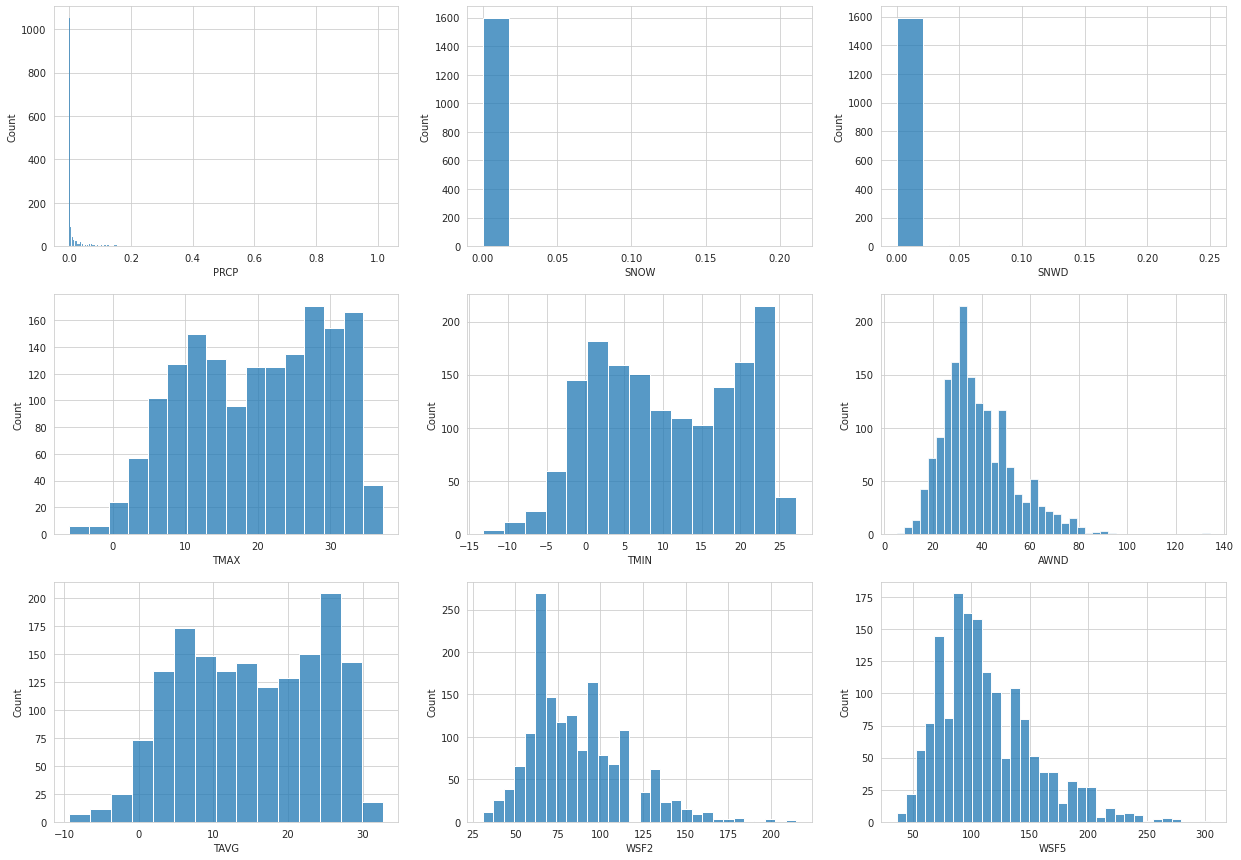

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(21, 15))
columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'TAVG', 'WSF2', 'WSF5']
indexes = list(itertools.product([0,1,2], [0,1,2]))
for col, idxs in zip(columns, indexes):
    i, j = idxs
    sns.histplot(data=df, ax=axs[i,j], x=col)
plt.show();

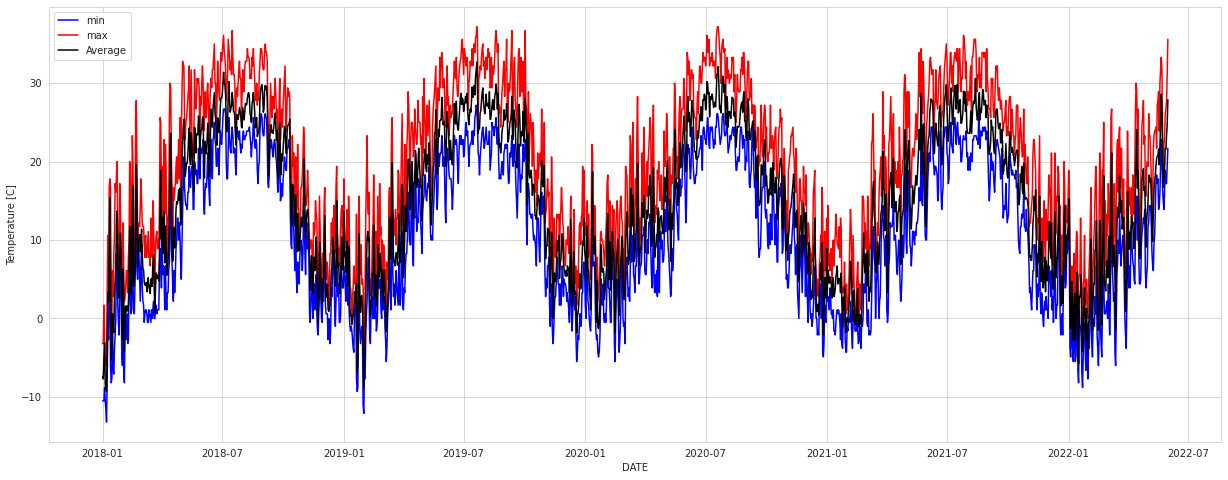

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(21, 8))
sns.lineplot(data=df, ax=ax, x="DATE", y="TMIN", color="b", label="min")
sns.lineplot(data=df, ax=ax, x="DATE", y="TMAX", color="r", label="max")
sns.lineplot(data=df, ax=ax, x="DATE", y="TAVG", color="k", label="Average")
plt.ylabel("Temperature [C]")
plt.show();

In [12]:
df[df["PRCP"] > 0.5]["PRCP"].count()

15

## Feature Engineering

Taking inspiration from the [UCI Bike Sharing Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset), we are going to create a feature that ranks the intensity of the weather on a 4-point scale:

0. Clear
1. Light Rain, Mist, Fog
2. Light Snow, Light Rain + Thunderstorm
3. Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog 

In [35]:
wx_df = (
    df.copy()
    .assign(WXSIT = 0)
    .assign(WXSIT = lambda df: df["WXSIT"]
                .add(df["WT13"])                    # Mist
                .add(df["WT01"])                    # Fog
                .add(df["PRCP"].gt(0).map(int))     # any rain
                .clip(upper=1))
    .assign(WXSIT = lambda df: df["WXSIT"]
                .add(2*df["WT02"])                    # Heavy fog
                .add(2*df["WT03"]) # thunder
                .add(2*df["PRCP"].gt(0.15).map(int))  # greater than 0.15 m (~6 in) of rain
                .add(2*df["SNOW"].gt(0).map(int))
                .add(2*df["WT08"])                    # Smoke or haze
                .clip(upper=2))
    .assign(WXSIT = lambda df: df["WXSIT"]
                .add(3*df["WT04"])                    # Ice pellets, sleet, snow pellets, or small hail
                .add(3*df["WT05"])                    # Hail
                .add(3*df["WT09"])                    # Blowing or drifting snow
                .add(3*df["PRCP"].gt(0.3).map(int))  # greater than 0.3 m (~12 in) of rain
                .clip(upper=3))
    .drop(columns=[x for x in df.columns if "WT" in x])
)

wx_df["WXSIT"].value_counts()

0.0    871
2.0    363
1.0    308
3.0     70
Name: WXSIT, dtype: int64

<AxesSubplot:xlabel='WXSIT', ylabel='Count'>

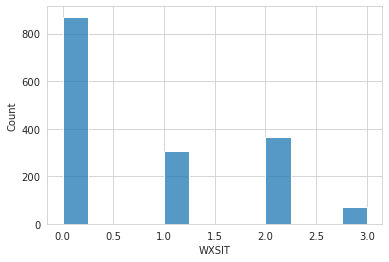

In [36]:
sns.histplot(data=wx_df, x="WXSIT")